In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('final_dataset_Infilteration.csv')

X = data.drop(['Timestamp', 'Label'], axis=1)
y = data['Label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [3]:
corr_matrix = data.drop(['Timestamp'], axis=1).corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


In [4]:
# Select top 15 features based on correlation with label
best_features_15 = upper_tri.nlargest(15, 'Label')['Label'].index.tolist()

# Select top 20 features based on correlation with label
best_features_20 = upper_tri.nlargest(20, 'Label')['Label'].index.tolist()

# Select top 30 features based on correlation with label
best_features_30 = upper_tri.nlargest(30, 'Label')['Label'].index.tolist()

# Loop through all feature sets
for feature_set in [best_features_15, best_features_20, best_features_30]:

    # Convert feature names to indices
    feature_indices = [X.columns.get_loc(feature_name) for feature_name in feature_set]
    X_train_subset = X_train[:, feature_indices]
    X_test_subset = X_test[:, feature_indices]

    # Reshape X_train and X_test to match LSTM input shape
    X_train_subset = X_train_subset.reshape((X_train_subset.shape[0], 1, X_train_subset.shape[1]))
    X_test_subset = X_test_subset.reshape((X_test_subset.shape[0], 1, X_test_subset.shape[1]))

    # Create and fit LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_subset.shape[1], X_train_subset.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_subset, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
23460/23460 [==============================] - 161s 7ms/step - loss: 0.4524 - accuracy: 0.8273
Epoch 2/10
23460/23460 [==============================] - 114s 5ms/step - loss: 0.4483 - accuracy: 0.8274
Epoch 3/10
23460/23460 [==============================] - 107s 5ms/step - loss: 0.4464 - accuracy: 0.8274
Epoch 4/10
23460/23460 [==============================] - 89s 4ms/step - loss: 0.4455 - accuracy: 0.8274
Epoch 5/10
23460/23460 [==============================] - 89s 4ms/step - loss: 0.4450 - accuracy: 0.8273
Epoch 6/10
23460/23460 [==============================] - 103s 4ms/step - loss: 0.4447 - accuracy: 0.8274
Epoch 7/10
23460/23460 [==============================] - 105s 4ms/step - loss: 0.4445 - accuracy: 0.8273
Epoch 8/10
23460/23460 [==============================] - 109s 5ms/step - loss: 0.4443 - accuracy: 0.8273
Epoch 9/10
23460/23460 [==============================] - 107s 5ms/step - loss: 0.4442 - accuracy: 0.8274
Epoch 10/10
23460/23460 [=======================

AttributeError: 'Sequential' object has no attribute 'predict_classes'

5865/5865 [==============================] - 22s 4ms/step
Feature set: ['Fwd Seg Size Min', 'Fwd Pkt Len Mean', 'Fwd Seg Size Avg', 'Bwd Pkts/s', 'PSH Flag Cnt', 'Pkt Size Avg', 'Fwd Pkt Len Max', 'Pkt Len Mean', 'Fwd URG Flags', 'CWE Flag Count', 'Fwd Pkt Len Std', 'Pkt Len Max', 'Pkt Len Std', 'Fwd IAT Mean', 'Protocol_6']
Accuracy: 0.8275149190110827


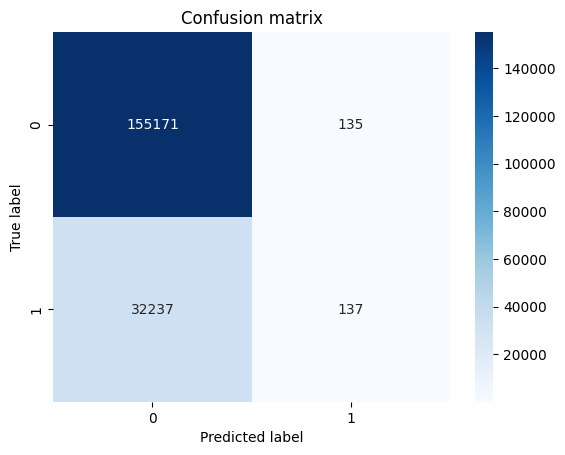

In [5]:
    # Make predictions and calculate accuracy
    y_pred_prob = model.predict(X_test_subset)
    y_pred = np.round(y_pred_prob)
    accuracy = accuracy_score(y_test, y_pred)
    print('Feature set:', feature_set)
    print('Accuracy:', accuracy)

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')
    plt.show()